1 Data Synthesis

In [93]:
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs

#number of samples
n_samples = 500

#Moons
moons_data, _ = make_moons(n_samples=n_samples, noise=0.05, random_state=42)
moons_S = -np.linalg.norm(moons_data[:, np.newaxis] - moons_data[np.newaxis, :], axis=2)**2

#Circles
circles_data, _ = make_circles(n_samples=n_samples, factor=0.3, noise=0.07, random_state=42)
circles_S = -np.linalg.norm(circles_data[:, np.newaxis] - circles_data[np.newaxis, :], axis=2)**2

#Blobs
blob_centers = [(-6, 2), (-1, 5), (5, -4)]
blob_std = [0.5, 1.5, 2.0]
blobs_data, _ = make_blobs(n_samples=n_samples, centers=blob_centers, cluster_std=blob_std, random_state=42)
blobs_S = -np.linalg.norm(blobs_data[:, np.newaxis] - blobs_data[np.newaxis, :], axis=2)**2

2 Data Exploration

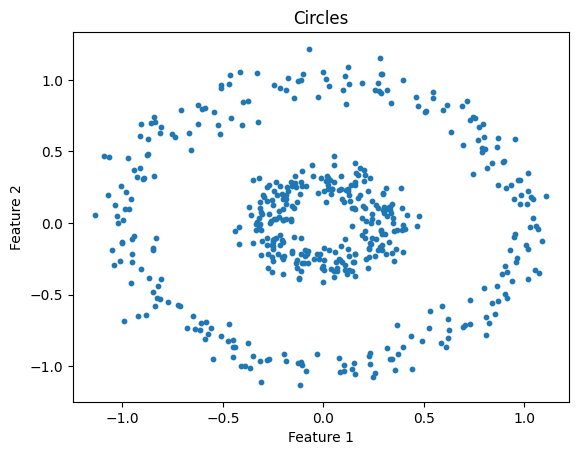

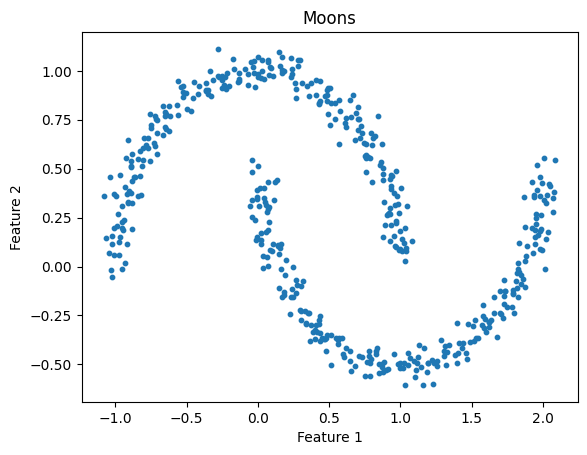

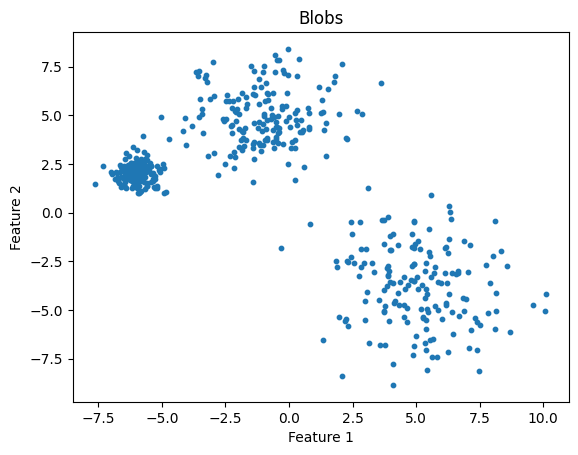

In [94]:
import matplotlib.pyplot as plt

def plot_dataset(input_data, title):
    plt.scatter(input_data[:, 0], input_data[:, 1], s=10)
    plt.title(title)
    plt.xlabel('Feature 1') 
    plt.ylabel('Feature 2')
    plt.show()
plot_dataset(circles_data,'Circles')
plot_dataset(moons_data,'Moons')
plot_dataset(blobs_data,'Blobs')


 3 Implementing the Clustering Algorithm

In [95]:
def affinity_propagation(S,  damping, preference,convergence_iter=15, max_iter=500, noise=0):
   
    np.random.seed(42)
    n = S.shape[0]
    #S += noise * np.random.randn(*S.shape)

    R = np.zeros((n, n))  
    A = np.zeros((n, n))  

    # Apply preference
    if preference is not None:
        np.fill_diagonal(S, preference)

    E_old = None
    no_change_count = 0

    for iteration in range(max_iter):
        # Update responsibility
        AS = A + S
        max_AS = np.max(AS, axis=1, keepdims=True)
        idx_max_AS = np.argmax(AS, axis=1)

        second_max_AS = np.where(
            np.arange(n).reshape(-1, 1) != idx_max_AS.reshape(-1, 1), AS, -np.inf
        ).max(axis=1, keepdims=True)

        R_new = S - max_AS
        R_new[np.arange(n), idx_max_AS] = S[np.arange(n), idx_max_AS] - second_max_AS.flatten()
        R = damping * R + (1 - damping) * R_new

        # Update availability
        Rp = np.maximum(R, 0)
        np.fill_diagonal(Rp, np.diag(R))

        A_new = np.minimum(0, Rp.sum(axis=0, keepdims=True) - Rp)
        np.fill_diagonal(A_new, Rp.sum(axis=0))
        A = damping * A + (1 - damping) * A_new

        # Check for convergence
        E = (A + R) > 0
        cluster_centers = np.where(np.diag(E))[0]

        if iteration >= convergence_iter:
            if E_old is not None and np.array_equal(E, E_old):
                no_change_count += 1
            else:
                no_change_count = 0

            if no_change_count >= convergence_iter:
                break

        E_old = E.copy()

    # Determine clusters
    clusters = np.argmax(A + R, axis=1)
    exemplar_indices = np.where(np.diag(A + R) > 0)[0]
    return clusters, exemplar_indices

4 Hyperparameters

In [96]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from itertools import product


np.random.seed(42)
# parameters
damping_values = np.arange(0.9, 1.0, 0.1)  
preference_values = np.arange(-500, -450, 50)  
all_results = []

# gridy search
def grid_search(data_name, data, S):
    print(f"Performing Grid Search for {data_name} dataset...")
    results = []

    for damping, preference in product(damping_values, preference_values):
        clusters, _ = affinity_propagation(S, damping=damping, preference=preference)
        num_clusters = len(np.unique(clusters))
        
        sil_score = silhouette_score(data, clusters)
        calinski_score = calinski_harabasz_score(data, clusters)
        davies_score = davies_bouldin_score(data, clusters)
        
        results.append((data_name, damping, preference, num_clusters, sil_score, calinski_score, davies_score))

    return results

datasets = {"Moons": (moons_data, moons_S), "Circles": (circles_data, circles_S), "Blobs": (blobs_data, blobs_S)}
for dataset_name, (data, S) in datasets.items():
    dataset_results = grid_search(dataset_name, data, S)
    all_results.extend(dataset_results)

df_results = pd.DataFrame(all_results, columns=["Dataset", "Damping", "Preference", 
                                               "Number of Clusters", "Silhouette Score", 
                                               "Calinski-Harabasz Score", "Davies-Bouldin Score"])


def combined_score(row):
    w_sil = 1
    w_calinski = 1
    w_davies = 1
    w_clusters = 1 

    # Normalize scores between 0 and 1
    sil_norm = (row["Silhouette Score"] - df_results["Silhouette Score"].min()) / (df_results["Silhouette Score"].max() - df_results["Silhouette Score"].min())
    calinski_norm = (row["Calinski-Harabasz Score"] - df_results["Calinski-Harabasz Score"].min()) / (df_results["Calinski-Harabasz Score"].max() - df_results["Calinski-Harabasz Score"].min())
    davies_norm = (df_results["Davies-Bouldin Score"].max() - row["Davies-Bouldin Score"]) / (df_results["Davies-Bouldin Score"].max() - df_results["Davies-Bouldin Score"].min())  
    clusters_norm = (df_results["Number of Clusters"].max() - row["Number of Clusters"]) / (df_results["Number of Clusters"].max() - df_results["Number of Clusters"].min())  

    score = w_sil * sil_norm + w_calinski * calinski_norm + w_davies * davies_norm + w_clusters * clusters_norm
    return score

df_results["Combined Score"] = df_results.apply(combined_score, axis=1)

# a few random samples
print("\nRandom Samples:")
for _ in range(2):  
    print(df_results.sample(n=1).to_markdown(numalign="left", stralign="left"))

# best result based on the combined score
best_results_combined = df_results.loc[df_results.groupby("Dataset")["Combined Score"].idxmax()]

# Print the best results
print("\nBest Overall Results for each dataset (based on Combined Score):")
print(best_results_combined.to_markdown(numalign="left", stralign="left"))

Performing Grid Search for Moons dataset...
Performing Grid Search for Circles dataset...
Performing Grid Search for Blobs dataset...

Random Samples:
|    | Dataset   | Damping   | Preference   | Number of Clusters   | Silhouette Score   | Calinski-Harabasz Score   | Davies-Bouldin Score   | Combined Score   |
|:---|:----------|:----------|:-------------|:---------------------|:-------------------|:--------------------------|:-----------------------|:-----------------|
| 0  | Moons     | 0.9       | -500         | 3                    | -0.0179173         | 266.592                   | 5.38651                | 1.86162          |
|    | Dataset   | Damping   | Preference   | Number of Clusters   | Silhouette Score   | Calinski-Harabasz Score   | Davies-Bouldin Score   | Combined Score   |
|:---|:----------|:----------|:-------------|:---------------------|:-------------------|:--------------------------|:-----------------------|:-----------------|
| 1  | Circles   | 0.9       | -500    

5 Evaluation

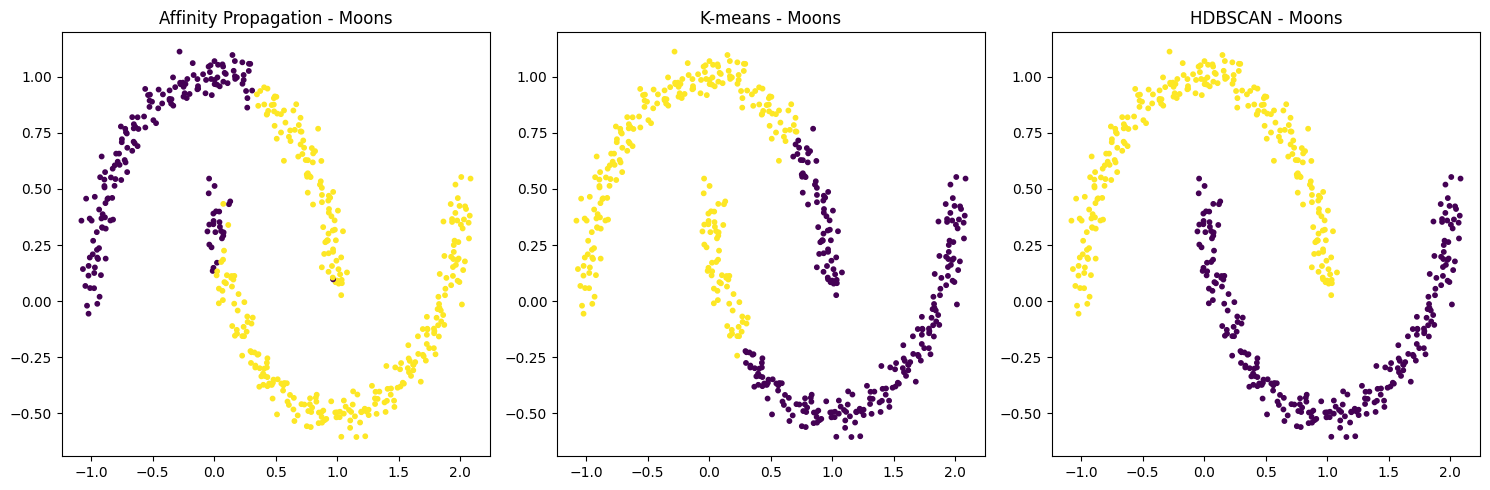

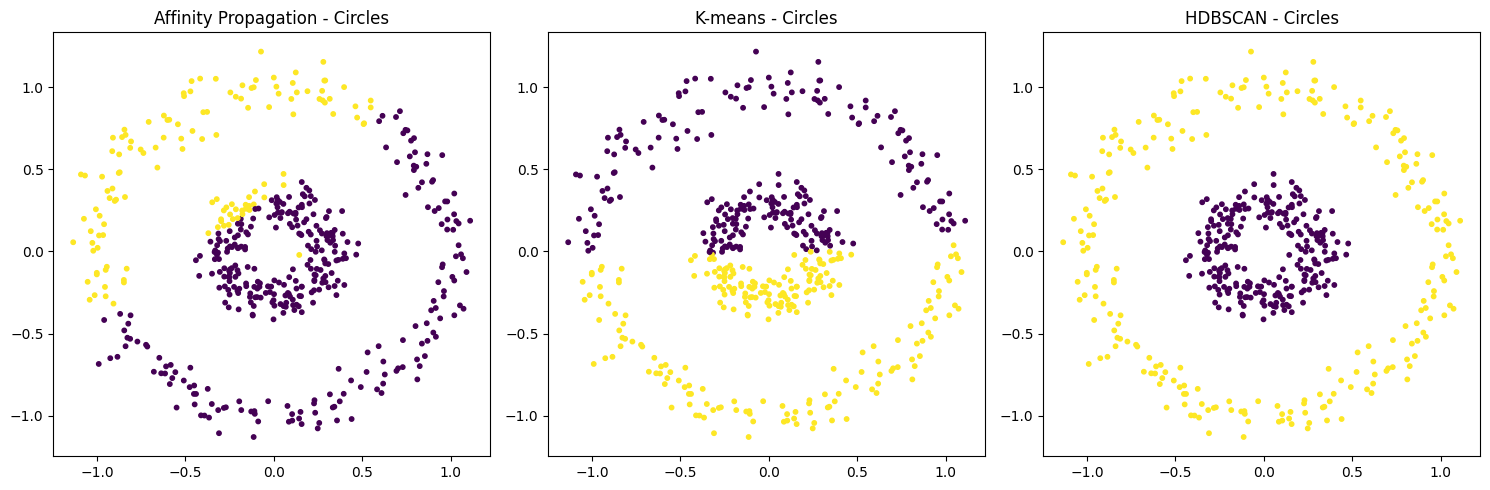

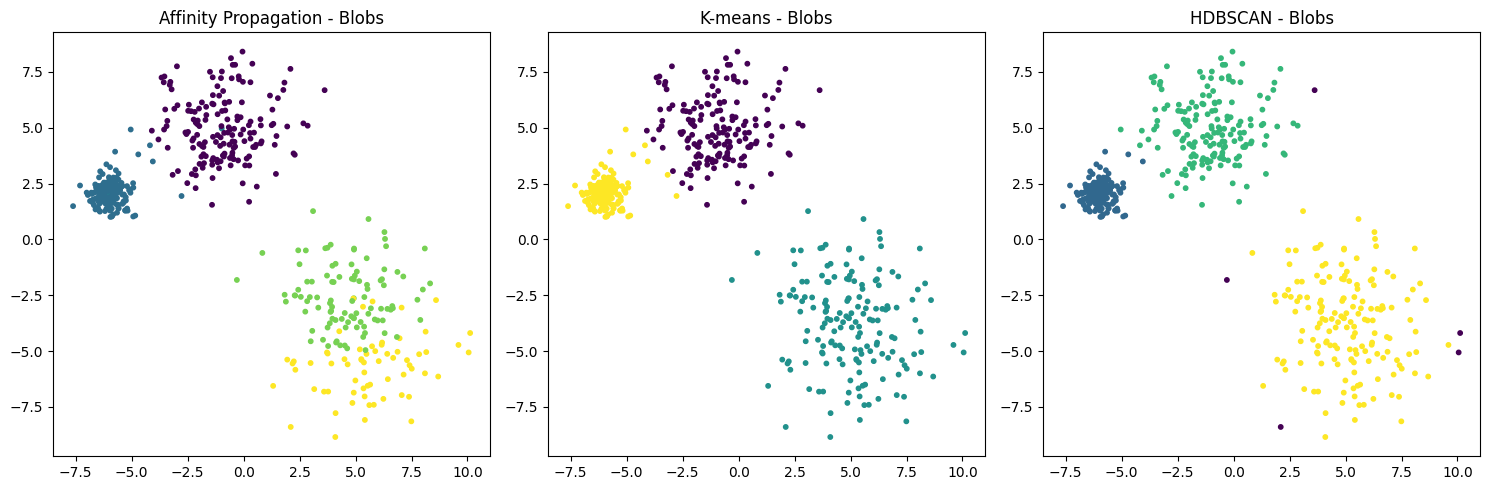

--- Moons Dataset ---
AP:
  Number of clusters: 2
  Silhouette Score: 0.455
  Calinski-Harabasz Index: 606.319
  Davies-Bouldin Index: 0.775
KMeans:
  Number of clusters: 2
  Silhouette Score: 0.489
  Calinski-Harabasz Index: 736.398
  Davies-Bouldin Index: 0.783
HDBSCAN:
  Number of clusters: 2
  Silhouette Score: 0.334
  Calinski-Harabasz Index: 332.49
  Davies-Bouldin Index: 1.152


--- Circles Dataset ---
AP:
  Number of clusters: 2
  Silhouette Score: 0.304
  Calinski-Harabasz Index: 193.009
  Davies-Bouldin Index: 1.256
KMeans:
  Number of clusters: 2
  Silhouette Score: 0.285
  Calinski-Harabasz Index: 222.643
  Davies-Bouldin Index: 1.329
HDBSCAN:
  Number of clusters: 2
  Silhouette Score: 0.203
  Calinski-Harabasz Index: 0.02
  Davies-Bouldin Index: 136.932


--- Blobs Dataset ---
AP:
  Number of clusters: 5
  Silhouette Score: 0.445
  Calinski-Harabasz Index: 1306.523
  Davies-Bouldin Index: 1.372
KMeans:
  Number of clusters: 3
  Silhouette Score: 0.686
  Calinski-Harabasz 

In [97]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan

np.random.seed(42)
def evaluate_clustering(X, labels):
    silhouette = round(silhouette_score(X, labels), 3)
    calinski_harabasz = round(calinski_harabasz_score(X, labels), 3)
    davies_bouldin = round(davies_bouldin_score(X, labels), 3)
    
    return {"Silhouette Score": silhouette,
            "Calinski-Harabasz Index": calinski_harabasz,
            "Davies-Bouldin Index": davies_bouldin}

def apply_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels

def apply_hdbscan(X):
    hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20)
    labels = hdbscan_model.fit_predict(X)
    return labels

# Example datasets and hyperparameters
datasets = {"Moons": (moons_data, moons_S, 2),  
            "Circles": (circles_data, circles_S, 2), 
            "Blobs": (blobs_data, blobs_S, 3)}

hyperparams = {
    "Moons": { "damping": 0.9, "preference": -300},
    "Circles": { "damping": 0.9, "preference": -300},
    "Blobs": {  "damping": 0.9, "preference": -350},
}

results = {}
for name, (dataset, sim_matrix, n_clusters_kmeans) in datasets.items():
    params = hyperparams[name]
    np.random.seed(42)
    # Affinity Propagation
    clusters_ap, centers_ap = affinity_propagation(
        sim_matrix, 
        damping=params["damping"],
        preference=params["preference"]
    )
    n_clusters_ap = len(np.unique(clusters_ap))
    results[name] = {
        "AP": {
            "clusters": clusters_ap,
            "centers": centers_ap,
            "n_clusters": n_clusters_ap,
            "metrics": evaluate_clustering(dataset, clusters_ap)
        }
    }

    # K-means
    clusters_kmeans = apply_kmeans(dataset, n_clusters_kmeans)  
    results[name]["KMeans"] = {
        "clusters": clusters_kmeans,
        "metrics": evaluate_clustering(dataset, clusters_kmeans)}

    # HDBSCAN
    clusters_hdbscan = apply_hdbscan(dataset)
    results[name]["HDBSCAN"] = { "clusters": clusters_hdbscan,
        "metrics": evaluate_clustering(dataset, clusters_hdbscan)}

# Plot results
for name, (dataset, _, _) in datasets.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Affinity Propagation
    axes[0].scatter(dataset[:, 0], dataset[:, 1], c=results[name]["AP"]["clusters"], cmap='viridis', s=10)  
    axes[0].set_title(f"Affinity Propagation - {name}")

    # K-means
    axes[1].scatter(dataset[:, 0], dataset[:, 1], c=results[name]["KMeans"]["clusters"], cmap='viridis', s=10)
    axes[1].set_title(f"K-means - {name}")

    # HDBSCAN
    axes[2].scatter(dataset[:, 0], dataset[:, 1], c=results[name]["HDBSCAN"]["clusters"], cmap='viridis', s=10)
    axes[2].set_title(f"HDBSCAN - {name}")

    plt.tight_layout()
    plt.show()

# Print metrics
for name, result in results.items():
    print(f"--- {name} Dataset ---")
    for algorithm, data in result.items():
        print(f"{algorithm}:")
        
        if algorithm == "KMeans":
            n_clusters = len(np.unique(data["clusters"])) - (1 if -1 in data["clusters"] else 0)  
        elif algorithm == "HDBSCAN":
            n_clusters = len(np.unique(data["clusters"])) - (1 if -1 in data["clusters"] else 0)  
        else:
            n_clusters = data["n_clusters"]  

        print(f"  Number of clusters: {n_clusters}")
        for metric, value in data["metrics"].items():
            print(f"  {metric}: {value}")
    print("\n")
